DOMAIN:  Botanical Research

CONTEXT: University X is currently undergoing some research involving understanding the characteristics of plant and plant seedlings at various  stages  of  growth.  They  already  have  have  invested  on  curating  sample  images.  They  require  an  automation  which  can  create  a classifier capable of determining a plant's species from a photo

• DATA DESCRIPTION: The dataset comprises of images from 12 plant species.  
Source: https://www.kaggle.com/c/plant-seedlings-classification/data. 

• PROJECT OBJECTIVE: To create a classifier capable of determining a plant's species from a photo. 

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


#Library Session

In [2]:
#import libraries
import pandas as pd #for reading the data in the form of dataframes
from tensorflow.keras.models import Sequential #for making the modeles
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout #Using the build the CNN network
from mpl_toolkits.axes_grid1 import ImageGrid
import os #operating system
from sklearn.metrics import confusion_matrix
import random
from keras.backend import batch_normalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import image
from keras.layers import BatchNormalization
from keras import backend as K 



In [3]:
from google.colab import drive #library to open the drive
drive.mount('/content/drive') #path for opening the file from the drive

Mounted at /content/drive


# 1.Import and Understand the data [12 Marks]

A.Extract ‘plant-seedlings-classification.zip’ into new folder (unzipped) using python. [2 Marks]Hint: You can extract it Manually by losing.

In [4]:
from zipfile import ZipFile #importing zipfile library for opening the zip file
with ZipFile("/content/drive/MyDrive/plant-seedlings-classification.zip",'r') as zip: #using the zip path for reading the zip file
  zip.extractall() #extracting the zip file

B.Map the images from train folder with train labels to form a DataFrame. [6 Marks]Hint: Create a DataFrame with 3 columns: Name of image, Species/class/type of image & actual image..

In [5]:
#making a list of categorys which were given
class_names = ["Black-grass","Charlock","Cleavers","Common Chickweed","Common wheat","Fat Hen","Loose Silky-bent","Maize","Scentless Mayweed","Shepherds Purse","Small-flowered Cranesbill","Sugar beet"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)} #assinging numbers to the labels

nb_classes = len(class_names)  #getting the length of the categories present in the training list
class_name_labels #printing the labels with the numbers

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [6]:
!ls #getting the directory of the existing file plant-seedlings-classification

drive  __MACOSX  plant-seedlings-classification  sample_data


In [7]:
train_dir = "/content/plant-seedlings-classification/train" #assinging the train path

In [8]:
#here we are printing the number of images in each category
for category in class_names: #getting the categories from the list of the class_names
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category))))) #printing the number of the images in the files

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


In [9]:
train = [] #assinging the empty list
for category_id, category in enumerate(class_names): #
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])

train.shape

(4750, 3)

In [10]:
#Name of image, Species/class/type of image & actual image..

#Name of image --> Category
#Actual Image --> with the image name with the file path
#Species/class/type --> Category_id

train.sample(12)

,file,category_id,category
1334,train/Common Chickweed/50659ebe2.png,3,Common Chickweed
1529,train/Common Chickweed/cba7f2307.png,3,Common Chickweed
878,train/Cleavers/360f883f6.png,2,Cleavers
4625,train/Sugar beet/22d2590d3.png,11,Sugar beet
2578,train/Loose Silky-bent/9cf880bda.png,6,Loose Silky-bent
1229,train/Common Chickweed/5ba9f6698.png,3,Common Chickweed
1873,train/Fat Hen/0c03386a9.png,5,Fat Hen
1012,train/Common Chickweed/63e5b3269.png,3,Common Chickweed
572,train/Charlock/3b2ae0151.png,1,Charlock
540,train/Charlock/ec84cacfe.png,1,Charlock


C.Write a function that will select n random images and display images along with its species. [4 Marks]Hint: If input for function is 5, it should print 5 random images along with its labels

In [11]:
 #defining a function to printing the requested number of random images (i have used random.choice and matplotlib.pyplot for printing the images)
 def images(value):
      data_dir = '/content/plant-seedlings-classification'
      filepath = '/content/plant-seedlings-classification/train'
      img_folder=r'/content/plant-seedlings-classification/train' #giving the folder path
      plt.figure(figsize=(25,35)) #giving the figure size
      for i in range(value): 
          
          image_path= os.path.join(data_dir, filepath) #getting the file path
          img=plt.imread('/content/plant-seedlings-classification/'+train["file"][i]) #ploting the figure 
          ax=plt.subplot(1,value,i+1) #creating subplot
          ax.title.set_text(train['category'][i]) #setting the figure name
          plt.imshow(img) #printing the image

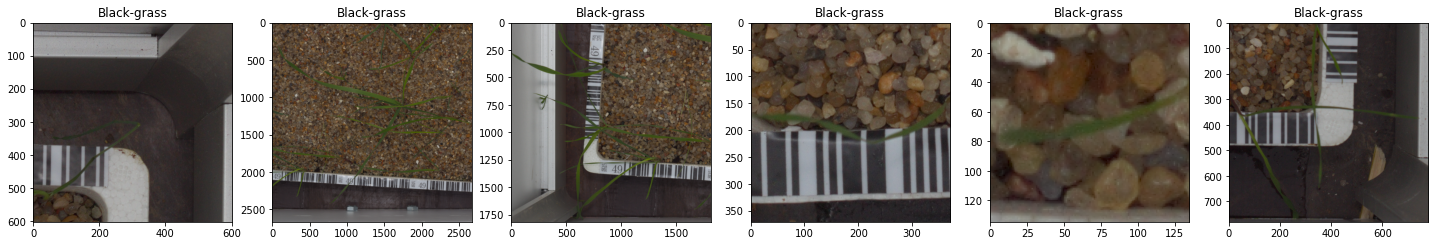

In [12]:
images(6)

#Doing some experiment with the images (Creating the Mask)

Besides of this, we'll blur image firstly for removing noise. After creating HSV image, we'll create mask based on empirically selected range of green color, convert it to boolean mask and apply it to the origin image.

For creating mask, which will remove background, we need to convert RGB image to HSV. HSV is alternative of the RGB color model. In HSV, it is easier to represent a color range than in RGB color space.

--> Convert color to HSV

--> Create mask

--> Create boolean mask

--> Apply boolean mask and getting image whithout background

In [13]:
#practice
import cv2
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

ScaleTo = 70  # px to scale
seed = 7  # fixing random

path = '/content/plant-seedlings-classification/train/*/*.png'
files = glob(path)

trainImg = []
trainLabel = []
j = 1
num = len(files)

# Obtain images and resizing, obtain labels

for img in files:
  
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))   # Get image (with resizing)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

<Figure size 640x480 with 0 Axes>

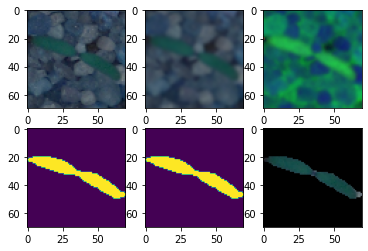

In [14]:
clearTrainImg = []
examples = []; getEx = True
for img in trainImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTrainImg.append(clear)  # Append image without background
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

clearTrainImg = np.asarray(clearTrainImg)

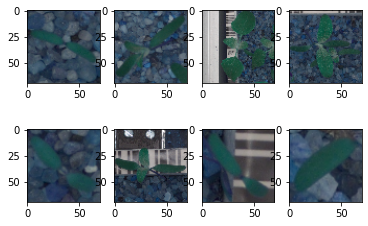

In [15]:
# Show some example images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(trainImg[i])

As we can see, every photo of plant seedling has an background, so let's try to remove it. It'll help us to goal better model accuracy

Good result! Let's look at other examples of masked images

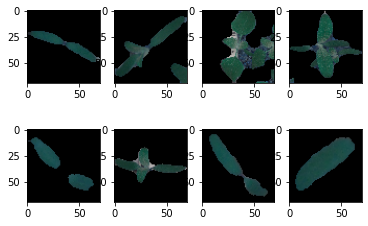

In [16]:
# Show sample result
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTrainImg[i])

2.2. Normalize input

Now set the values of input from [0...255] to [0...1] (RGB color-space encode colors with numbers [0...255]). CNN will be faster train if we use [0...1] input

In [17]:
clearTrainImg = clearTrainImg / 255

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


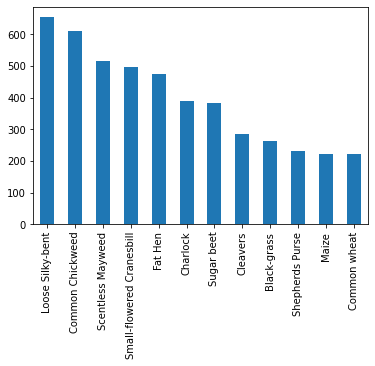

In [18]:
from keras.utils import np_utils
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Encode labels and create classes
le = preprocessing.LabelEncoder()
le.fit(trainLabel[0])
print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(trainLabel[0])

# Make labels categorical
clearTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_clases))

# Plot of label types numbers
trainLabel[0].value_counts().plot(kind='bar')

As we can see, we have different counts of images of different species. So, data is unbalanced

# 2. Data preprocessing [8 Marks]

A. Create X & Y from the DataFrame. [2 Marks]

In [19]:
x = train['file']
y = train["category"]

B. Encode labels of the images. [2 Marks]

In [20]:
# Encode labels and create classes
le = preprocessing.LabelEncoder()
le.fit(y)
print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(y)

# Make labels categorical
clearTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_clases))

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


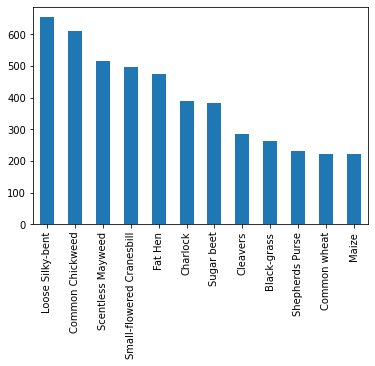

In [21]:
# Plot of label types numbers
y.value_counts().plot(kind='bar')


C. Unify shape of all the images. [2 Marks]

In [22]:
figure(figsize=(8, 6), dpi=80)

ScaleTo = 70  # px to scale

path = '/content/plant-seedlings-classification/' 
files = glob(path)

trainImg = []

# Obtain images and resizing, obtain labels

for img in path+x:
    trainImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))   # Get image (with resizing)
    
trainImg = np.asarray(trainImg)  # Train images set converting them into arrays


<Figure size 640x480 with 0 Axes>

D. Normalise all the images. [2 Marks]

Now set the values of input from [0...255] to [0...1] (RGB color-space encode colors with numbers [0...255]). CNN will be faster train if we use [0...1] input

In [23]:
trainImg = trainImg / 255

# 3. Model training [10 Marks]
Checkpoint: Please make sure if shape of X is (No.of images, height, width, No. Of channels). If not, you need to correct it otherwise it will be issue during model training.


A. Split the data into train and test data. [2 Marks]


Split data on training and validation set. 10% of data became the validation set



Our data is unbalanced, so for avoide inaccurate evaluation of model set stratify=clearTrainLabel

In [24]:
trainX, testX, trainY, testY = train_test_split(trainImg, clearTrainLabel, 
                                                test_size=0.3, random_state=7, 
                                                stratify = clearTrainLabel)

In [25]:
print('TrainX shape :-',trainX.shape)
print('TrainY shape :- ',trainY.shape)
print('TestX shape :-', testX.shape)
print('TestY shape :- ',testY.shape)

TrainX shape :- (3325, 70, 70, 3)
TrainY shape :-  (3325, 12)
TestX shape :- (1425, 70, 70, 3)
TestY shape :-  (1425, 12)


**Data Generator**


To avoide overfitting we need to create image generator which will randomly rotate,zoom,shift and flip image during the fitting of the model.

Set random rotation from 0 to 180 degress
Set random zoom at 0.1
Set random shifting at 0.1
Set horizontal and vertical flips

In [26]:
datagen = ImageDataGenerator(
    rotation_range=180, #randomly rotate images in the range
    zoom_range = 0.1, #ramdom zoom image
    width_shift_range=0.1, # randomly shift images horizontally
    height_shift_range=0.1, #randomly flip images horizontally
    vertical_flip=True #randomly flip images vertically
)


In [27]:
train_generator = datagen.flow(trainX,trainY,batch_size=15,shuffle=True,seed=42)

In [28]:
validation_generator = datagen.flow(testX,testY,batch_size=15,shuffle=True,seed=12)

B. Create new CNN architecture to train the model. [4 Marks]


First two convolutional layers have 64 filters,

After every layer i am creating max pooling layer

In [29]:
model = Sequential()
model.add(Conv2D(filters=64,kernel_size=(5,5),input_shape=(ScaleTo,ScaleTo,3),activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization(axis=(3)))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128,kernel_size=(5,5),activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256,kernel_size=(5,5),activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization(axis=3))
model.add((Dropout(0.1)))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(nb_classes,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 66, 66, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 66, 66, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        102464    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 31, 31, 64)       256       
 hNormalization)                                                 
                                                        

In [30]:
#compile model
#Using the Adam optimiser with learning rate set at 0.001 as this is currently giving the most optimal model.
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

C. Train the model on train data and validate on test data. [2 Marks]


Training the model 

Firstly we try to reduce the learning rate because if the learning rate is high the model would go to local minima

monitor: quantity to be monitored.
    factor: factor by which the learning rate will be reduced.
      new_lr = lr * factor.
    patience: number of epochs with no improvement after which learning rate
      will be reduced.
    verbose: int. 0: quiet, 1: update messages.
    mode: one of {'auto', 'min', 'max'}. In 'min' mode,
      the learning rate will be reduced when the
quantity monitored has stopped decreasing; in 'max' mode it will be
reduced when the quan

    min_lr: lower bound on the learning rate.



ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch', options=None, initial_value_threshold=None, **kwargs)    

In [31]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,
                             save_best_only=True,mode="max")
callbacks_list = [checkpoint]

In [32]:
epochs = 20
batch_size = 15
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.n//batch_size,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=validation_generator.n//batch_size,
                              callbacks=callbacks_list,
                              verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/20
221/221 [==============================] - ETA: 0s - loss: 2.7852 - accuracy: 0.2293
Epoch 1: val_accuracy improved from -inf to 0.13965, saving model to model_weights.h5
221/221 [==============================] - 403s 2s/step - loss: 2.7852 - accuracy: 0.2293 - val_loss: 6.7264 - val_accuracy: 0.1396
Epoch 2/20
221/221 [==============================] - ETA: 0s - loss: 2.1338 - accuracy: 0.3350
Epoch 2: val_accuracy improved from 0.13965 to 0.16000, saving model to model_weights.h5
221/221 [==============================] - 405s 2s/step - loss: 2.1338 - accuracy: 0.3350 - val_loss: 4.2023 - val_accuracy: 0.1600
Epoch 3/20
221/221 [==============================] - ETA: 0s - loss: 1.8755 - accuracy: 0.3931
Epoch 3: val_accuracy improved from 0.16000 to 0.27930, saving model to model_weights.h5
221/221 [==============================] - 404s 2s/step - loss: 1.8755 - accuracy: 0.3931 - val_loss: 2.9399 - val_accuracy: 0.2793
Epoch 4/20
221/221 [==============================] 

In [33]:
model.evaluate(testX, testY)

45/45 [==============================] - 37s 824ms/step - loss: 0.5143 - accuracy: 0.8281


[0.514302134513855, 0.8280701637268066]

In [34]:
#Creating the function to generate an output for visualizing the Loss and Accuracy of the model
def show_final_history(history):
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title("Loss")
    ax[1].set_title("Accuracy")
    ax[0].plot(history.history["loss"],label="Loss")
    ax[0].plot(history.history["val_loss"],label="Test Loss")
    ax[1].plot(history.history["accuracy"],label="Accuracy")
    ax[1].plot(history.history["val_accuracy"],label="Test Accuracy")
    
    ax[0].legend(loc="upper right")
    ax[1].legend(loc="lower right")

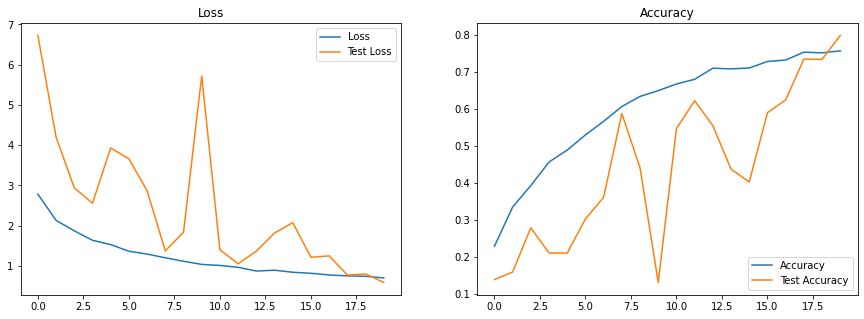

In [35]:
show_final_history(history)

D. Select a random image and print actual label and predicted label for the same. [2 Marks]

In [36]:
y_test = np.argmax(testY,axis=1)
y_test.shape,validation_generator.n

((1425,), 1425)

In [37]:
val_pred = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in val_pred]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [38]:
y_pred = np.argmax(val_pred,axis=1)
y_pred.shape

(1425,)

<Figure size 432x288 with 0 Axes>

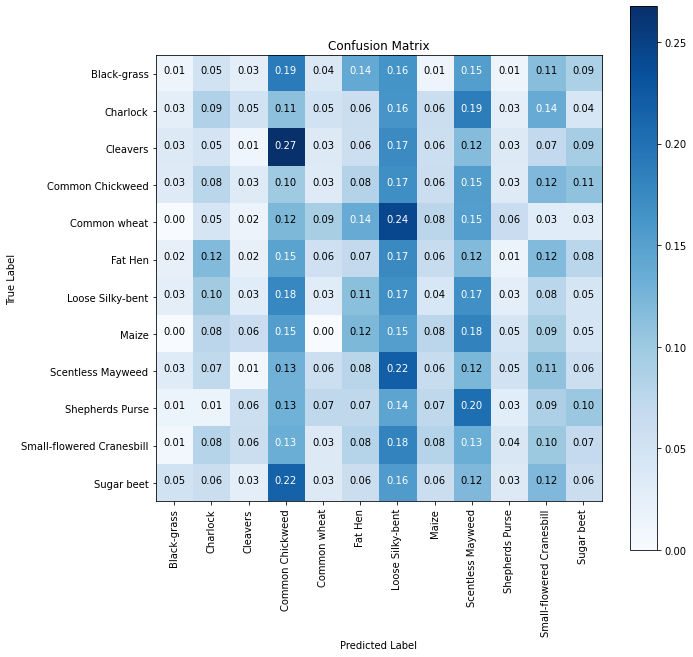

In [39]:
import itertools

def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):
    
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

cnf_mat = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)


plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.show()

In [40]:
test_dir = ['/home/fai/Downloads']

In [41]:
test_dir = ["../home/fai/Downloads/test"]

def load_test():
    
    images,names = [],[]
    for dataset in test_dir:

        for file in tqdm(os.listdir(dataset)):
            
            img_path = os.path.join(dataset,file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = cv2.resize(img,(150,150))

            images.append(img)
            names.append(file)
            pass
        
        images = np.array(images,dtype=np.float32)
        pass
    
    return images,names
    pass

Predicted label: 10
Softmax Outputs: [[4.36e-04 7.58e-04 4.76e-04 1.36e-02 4.15e-05 3.15e-03 2.58e-04 2.79e-03
  6.63e-05 4.06e-04 9.29e-01 4.88e-02]]
0.99999994


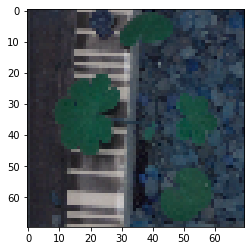

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.imshow(testX[1],cmap='gray')
y_pred = model.predict(testX[1].reshape(1,70,70,3))
print("Predicted label:", y_pred.argmax())
print("Softmax Outputs:", y_pred)
print(y_pred.sum())

# PART- B

DOMAIN: Botanical Research


• CONTEXT: University X is currently undergoing some research involving understanding the characteristics of flowers. They already have
have invested on curating sample images. They require an automation which can create a classifier capable of determining a flower’s species from a photo.

• DATA DESCRIPTION: The dataset comprises of images from 17 plant species.

• PROJECT OBJECTIVE: To experiment with various approaches to train an image classifier to predict type of flower from the image.


## 1. Import and Understand the data [5 Marks]


In [46]:
!pip install tflearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 107 kB 26.9 MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=3d9742c38d5348b010205b5f4543a0d6e55bdd3de63c4f7a78601ca3f3153187
  Stored in directory: /root/.cache/pip/wheels/5f/14/2e/1d8e28cc47a5a931a2fb82438c9e37ef9246cc6a3774520271
Successfully built tflearn


In [69]:
from tflearn.datasets import oxflower17
import matplotlib.pyplot as plt
import pandas as pd
import warnings 
import tensorflow as tf
import random
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import cv2
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras import backend as k
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')
import cv2
import os
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import svm, metrics
from natsort import natsorted
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# from sklearn.grid_search import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, GridSearchCV
%matplotlib inline
import itertools

import tensorflow
from tensorflow.python.keras.layers import Dense, Dropout, InputLayer,  Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPool2D, GlobalMaxPool2D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator

A. Import and read oxflower17 dataset from tflearn and split into X and Y while loading. [2 Marks]
Hint: It can be imported from tflearn.datasets. If tflearn is not installed, install it.
It can be loaded using: x, y = oxflower17.load_data()


In [48]:
x,y = oxflower17.load_data()

100.0% 60276736 / 60270631


Succesfully downloaded 17flowers.tgz 60270631 bytes.
File Extracted
Starting to parse images...
Parsing Done!


B. Print Number of images and shape of the images. [1 Marks]


In [49]:
print(f'Shape of X:',x.shape)
print(f'Shape of Y:',y.shape)

Shape of X: (1360, 224, 224, 3)
Shape of Y: (1360,)


C. Print count of each class from y. [2 Marks]


In [50]:
pd.DataFrame(y).value_counts()#used pandas and value_counts

0     80
9     80
15    80
14    80
13    80
12    80
11    80
10    80
8     80
1     80
7     80
6     80
5     80
4     80
3     80
2     80
16    80
dtype: int64

In [51]:
num_classes = len(pd.DataFrame(y).value_counts())

## 2. Image Exploration & Transformation [Learning purpose - Not related to final model] [10 Marks]


A. Display 5 random images. [1 Marks]


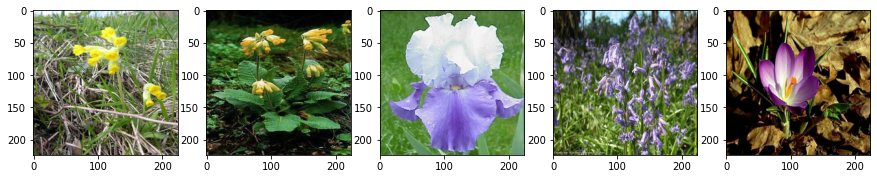

In [52]:
plt.figure(figsize=(15,15))
for i in range(5):
    
    plt.subplot(1,5,i+1)
    
    plt.imshow(x[i])
    

B. Select any image from the dataset and assign it to a variable. [1 Marks]


In [53]:
img = x[2]

C. Transform the image into grayscale format and display the same. [3 Marks]


Text(0.5, 1.0, 'GrayScale')

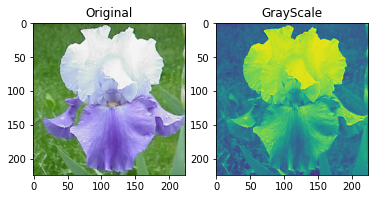

In [54]:
grayscale  = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.subplot(1,2,1);plt.imshow(img);plt.title("Original")
plt.subplot(1,2,2);plt.imshow(grayscale);plt.title("GrayScale")

D. Apply a filter to sharpen the image and display the image before and after sharpening. [2 Marks]


In [55]:
kernel1 = np.array([[0,0,0],
          [0,1,0],
          [0,0,0]])
sharpen = cv2.filter2D(img,ddepth = -1,kernel = kernel1)

Text(0.5, 1.0, 'Sharpen')

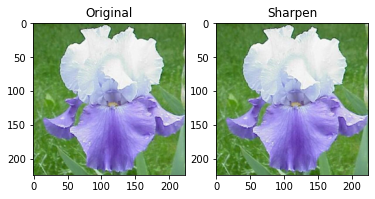

In [56]:
plt.subplot(1,2,1);plt.imshow(img);plt.title('Original')
plt.subplot(1,2,2);plt.imshow(sharpen);plt.title('Sharpen')

E. Apply a filter to blur the image and display the image before and after blur. [2 Marks]


In [57]:
Blur = cv2.GaussianBlur(img,ksize=(5,5),sigmaX=0)

Text(0.5, 1.0, 'Blur')

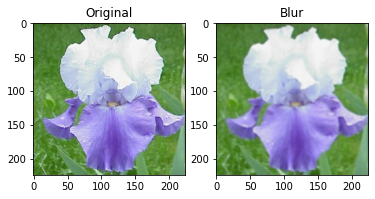

In [58]:
plt.subplot(1,2,1);plt.imshow(img);plt.title('Original')
plt.subplot(1,2,2);plt.imshow(Blur);plt.title('Blur')

F. Display all the 4 images from above questions besides each other to observe the difference. [1 Marks]


Text(0.5, 1.0, 'Blur')

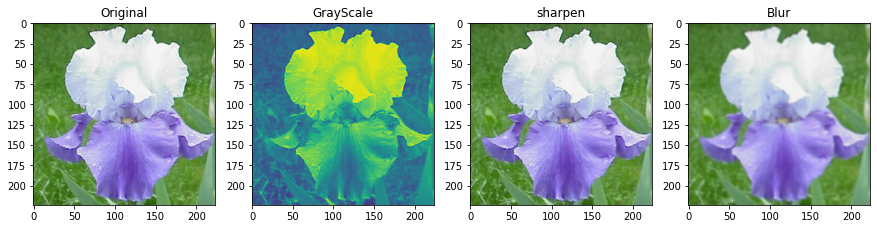

In [59]:
plt.figure(figsize=(15,15))
plt.subplot(1,4,1);plt.imshow(img);plt.title('Original')
plt.subplot(1,4,2);plt.imshow(grayscale);plt.title("GrayScale")
plt.subplot(1,4,3);plt.imshow(sharpen);plt.title('sharpen')
plt.subplot(1,4,4);plt.imshow(Blur);plt.title('Blur')

The shape of image to be predicted is:'(224, 224, 3)'
The shape of image to be predicted after expanding the dimensions is:'(1, 224, 224, 3)'


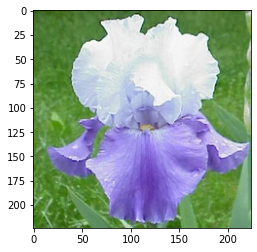

In [82]:
from google.colab.patches import cv2_imshow

plt.imshow(img)
img_predict = np.expand_dims(img, axis=0)
print(f"The shape of image to be predicted is:'{img.shape}'")
print(f"The shape of image to be predicted after expanding the dimensions is:'{img_predict.shape}'")

##3. Model training and Tuning: [15 Marks]


A. Split the data into train and test with 80:20 proportion. [2 Marks]

In [61]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=50)

In [62]:
random_seed = 2
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [63]:
print(f"#### Shapes of Train, Test and Validation sets of Target are: {y_train.shape},{y_test.shape},{y_val.shape}")

#### Shapes of Train, Test and Validation sets of Target are: (952,),(204,),(204,)


In [64]:
print(f"#### Shapes of Train, Test and Validation sets of Target are: {y_train.shape},{y_test.shape},{y_val.shape}")

#### Shapes of Train, Test and Validation sets of Target are: (952,),(204,),(204,)


B. Train a model using any Supervised Learning algorithm and share performance metrics on test data. [3 Marks]



    Support Vector Machines

The dataset have over 65536 features for each image and only 3336 images total in train dataset. To use an SVM, our model of choice, the number of features needs to be reduced.

PCA is a way of linearly transforming the data such that most of the information in the data is contained within a smaller number of features called components.


In [65]:
def flatten(X):
  Xr, Xg, Xb = [],[],[]
  for samples in X:
    r, g, b = cv2.split(samples)
    Xr.append(r.flatten())
    Xg.append(g.flatten())
    Xb.append(b.flatten())
  Xr = np.array(Xr)
  Xg = np.array(Xg)
  Xb = np.array(Xb)
  return (Xr, Xg, Xb)

In [66]:
X_train_r, X_train_g, X_train_b = flatten(X_train)
X_test_r, X_test_g, X_test_b = flatten(X_test)
X_val_r, X_val_g, X_val_b = flatten(X_val)

In [67]:
X_train_r.shape, X_train_g.shape, X_train_b.shape,
X_test_r.shape, X_test_g.shape, X_test_b.shape,
X_val_r.shape, X_val_g.shape, X_val_b.shape

((204, 50176), (204, 50176), (204, 50176))

In [71]:
n_components = 100
X_train_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_r)
X_train_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_g)
X_train_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_b)

X_test_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_r)
X_test_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_g)
X_test_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_b)

X_val_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_r)
X_val_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_g)
X_val_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_b)

In [72]:
Xr_train_pca = X_train_pca_r.transform(X_train_r)
Xg_train_pca = X_train_pca_g.transform(X_train_g)
Xb_train_pca = X_train_pca_b.transform(X_train_b)

Xr_test_pca = X_test_pca_r.transform(X_test_r)
Xg_test_pca = X_test_pca_g.transform(X_test_g)
Xb_test_pca = X_test_pca_b.transform(X_test_b)

Xr_val_pca = X_val_pca_r.transform(X_val_r)
Xg_val_pca = X_val_pca_g.transform(X_val_g)
Xb_val_pca = X_val_pca_b.transform(X_val_b)

In [73]:
X_train_pca_r.explained_variance_ratio_.sum(), X_train_pca_g.explained_variance_ratio_.sum(), X_train_pca_b.explained_variance_ratio_.sum(),
X_test_pca_r.explained_variance_ratio_.sum(), X_test_pca_g.explained_variance_ratio_.sum(), X_test_pca_b.explained_variance_ratio_.sum(),
X_val_pca_r.explained_variance_ratio_.sum(), X_val_pca_g.explained_variance_ratio_.sum(), X_val_pca_b.explained_variance_ratio_.sum()

(0.89443517, 0.8907254, 0.91512847)

In [74]:
X_train_pca = np.concatenate([Xr_train_pca,Xg_train_pca,Xb_train_pca], axis=1)
X_test_pca = np.concatenate([Xr_test_pca,Xg_test_pca,Xb_test_pca], axis=1)
X_val_pca = np.concatenate([Xr_val_pca,Xg_val_pca,Xb_val_pca], axis=1)

In [75]:
X_train_pca.shape, y_train.shape,
X_test_pca.shape, y_test.shape,
X_val_pca.shape, y_val.shape

((204, 300), (204,))

In [76]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = SVC()
clf = GridSearchCV(svc, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             verbose=10)

In [77]:
X_train.shape[0]

952

In [78]:
y_train.shape[0]

952

In [79]:
svm_score = clf.score(X_val_pca, y_val)

In [80]:
y_pred = clf.predict(X_test_pca)
svm_accuracy = metrics.accuracy_score(y_test, y_pred)

In [83]:
# Prediction using SVM

pred_img = np.squeeze(img_predict, axis=0)
X_pred_r, X_pred_g, X_pred_b = cv2.split(pred_img)

In [87]:
X_pred_pca_r = X_train_pca_r.transform(np.expand_dims(X_pred_r.flatten(), axis=0))
X_pred_pca_g = X_train_pca_g.transform(np.expand_dims(X_pred_g.flatten(), axis=0))
X_pred_pca_b = X_train_pca_b.transform(np.expand_dims(X_pred_b.flatten(), axis=0))

X_pred_pca = np.concatenate([X_pred_pca_r,X_pred_pca_g,X_pred_pca_b], axis=1)

In [88]:
pred_svm = clf.predict(X_pred_pca)[0]

print(f"The predicted label is:'{pred_svm}'")

The predicted label is:'12'


In [91]:
model_performance = pd.DataFrame(columns=['Model', 'Accuracy', 'Loss','Predicted Class'])

In [92]:
model_performance = model_performance.append({'Model':'SVM',
                                              'Accuracy': svm_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_svm                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.147059,NA,12


In [93]:
  #Random forest

param_grid=[
            {'n_estimators':[100,200],
             'min_samples_leaf':[2,3]}
           ]
rf = RandomForestClassifier()
clf = GridSearchCV(rf, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'min_samples_leaf': [2, 3],
                          'n_estimators': [100, 200]}],
             verbose=10)

In [94]:
rf_score = clf.score(X_val_pca, y_val)
y_pred = clf.predict(X_test_pca)
rf_accuracy = metrics.accuracy_score(y_test, y_pred)
pred_rf = clf.predict(X_pred_pca)[0]
print(f"The predicted label is:'{pred_rf}'")

The predicted label is:'12'


In [95]:
model_performance = model_performance.append({'Model':'RF',
                                              'Accuracy': rf_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_rf                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.147059,NA,12
1,RF,0.210784,NA,12


In [96]:
# 3. Decision Tree

from sklearn.tree import DecisionTreeClassifier
param_grid = [
              {'max_leaf_nodes': list(range(2, 100)), 
               'min_samples_split': [2, 3, 4]}
              ]
dt = DecisionTreeClassifier()
clf = GridSearchCV(dt, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca,y_train)

Fitting 5 folds for each of 294 candidates, totalling 1470 fits


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                             13, 14, 15, 16, 17, 18, 19, 20, 21,
                                             22, 23, 24, 25, 26, 27, 28, 29, 30,
                                             31, ...],
                          'min_samples_split': [2, 3, 4]}],
             verbose=10)

In [97]:
dt_score = clf.score(X_val_pca, y_val)
y_pred = clf.predict(X_test_pca)
dt_accuracy = metrics.accuracy_score(y_test, y_pred)
pred_dt = clf.predict(X_pred_pca)[0]
print(f"The predicted label is:'{pred_dt}'")

The predicted label is:'12'


In [98]:
model_performance = model_performance.append({'Model':'DT',
                                              'Accuracy': dt_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_dt                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.147059,NA,12
1,RF,0.210784,NA,12
2,DT,0.132353,NA,12


C. Train a model using Neural Network and share performance metrics on test data. [4 Marks]


ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    interpolation_order=1,
    dtype=None,
)

In [100]:
classes = np.array(y)

In [101]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y2 = enc.fit_transform(classes)

In [102]:
y2[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [103]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y2, test_size=0.3, random_state=50)

In [104]:
random_seed = 2
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [105]:
X_train.shape,y_train.shape

((952, 224, 224, 3), (952, 17))

In [106]:
num_classes = len(np.unique(y_train))
num_classes

2

In [107]:
def ann_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  # batch_size = None

  model = Sequential()

  model.add(InputLayer(input_shape=(height, width, num_channels)))

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(num_classes, activation = "softmax"))
  opt = tensorflow.keras.optimizers.Adam(lr=0.000001)
  model.compile(optimizer = opt, loss = loss, metrics = metrics)

  # model.summary()
  return model

In [108]:
ann = ann_model(256,256,3,17)

In [109]:
history = ann.fit(X_train, 
                  y_train, 
                  epochs = 50, 
                  validation_data = (X_val,y_val),
                  batch_size = 12)

Instructions for updating:
Colocations handled automatically by placer.


Train on 952 samples, validate on 204 samples
Epoch 1/50
952/952 [==============================] - 97s 102ms/sample - loss: 3.5174 - acc: 0.0651 - val_loss: 2.7820 - val_acc: 0.1127
Epoch 2/50
952/952 [==============================] - 103s 108ms/sample - loss: 3.0524 - acc: 0.1418 - val_loss: 2.7038 - val_acc: 0.1520
Epoch 3/50
952/952 [==============================] - 92s 96ms/sample - loss: 2.7929 - acc: 0.1870 - val_loss: 2.6040 - val_acc: 0.1912
Epoch 4/50
952/952 [==============================] - 92s 97ms/sample - loss: 2.6383 - acc: 0.2143 - val_loss: 2.4874 - val_acc: 0.2157
Epoch 5/50
952/952 [==============================] - 90s 95ms/sample - loss: 2.5165 - acc: 0.2647 - val_loss: 2.4276 - val_acc: 0.2402
Epoch 6/50
952/952 [==============================] - 93s 98ms/sample - loss: 2.3952 - acc: 0.2647 - val_loss: 2.3989 - val_acc: 0.2549
Epoch 7/50
952/952 [==============================] - 93s 98ms/sample - loss: 2.2930 - acc: 0.3004 - val_loss: 2.3631 - val_acc: 0.2598

In [110]:
ann_loss, ann_accuracy = ann.evaluate(X_test, y_test, verbose=1)
print('Test loss:', ann_loss)
print('Test accuracy:', ann_accuracy)

Test loss: 1.6846189031413956
Test accuracy: 0.5


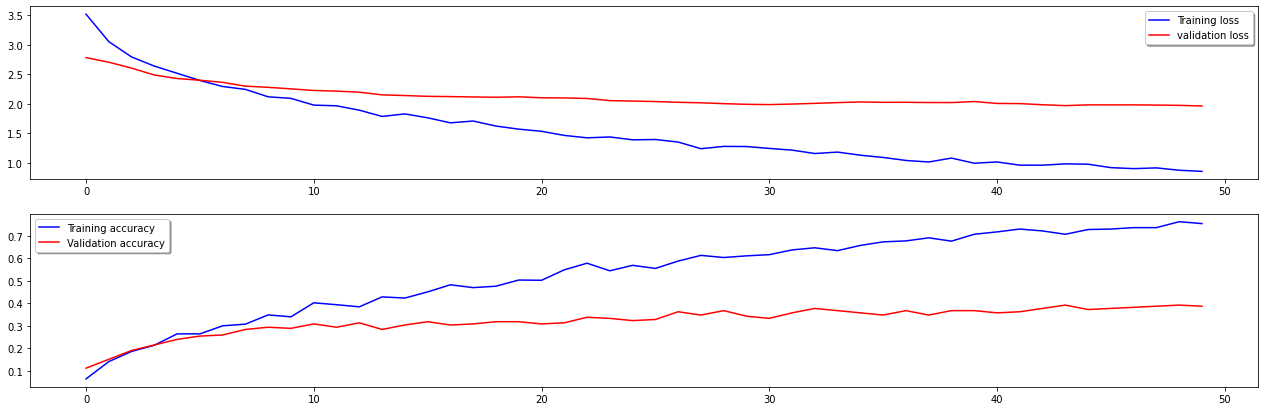

In [111]:
# Model Evaluation

fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [112]:
ann_predict = np.argmax(ann.predict(img_predict))

In [113]:
print('The predicted flower is with label:', ann_predict)

The predicted flower is with label: 12


In [114]:
model_performance = model_performance.append({'Model':'ANN',
                                              'Accuracy': ann_accuracy,
                                              'Loss': ann_loss,
                                              'Predicted Class': ann_predict                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.147059,NA,12
1,RF,0.210784,NA,12
2,DT,0.132353,NA,12
3,ANN,0.500000,1.684619,12


D.Train a model using a basic CNN and share performance metrics on test data. [4 Marks]



In [115]:
#Convolution Neural Network
def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))



  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

In [116]:
cnn = cnn_model(224,224,3,17)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      2432      
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 32)      25632     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 64)      36928     
                                                      

In [117]:
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 11, 
                  validation_data = (X_val,y_val),
                  batch_size = 32)

Train on 952 samples, validate on 204 samples
Epoch 1/50
952/952 [==============================] - 445s 468ms/sample - loss: 2.8398 - acc: 0.0504 - val_loss: 2.8331 - val_acc: 0.0539
Epoch 2/50
952/952 [==============================] - 441s 463ms/sample - loss: 2.8080 - acc: 0.0798 - val_loss: 2.7701 - val_acc: 0.1127
Epoch 3/50
952/952 [==============================] - 439s 461ms/sample - loss: 2.6387 - acc: 0.1239 - val_loss: 2.6418 - val_acc: 0.1863
Epoch 4/50
952/952 [==============================] - 437s 459ms/sample - loss: 2.5509 - acc: 0.1345 - val_loss: 2.5481 - val_acc: 0.1716
Epoch 5/50
952/952 [==============================] - 438s 460ms/sample - loss: 2.5021 - acc: 0.1429 - val_loss: 2.6153 - val_acc: 0.1225
Epoch 6/50
952/952 [==============================] - 438s 460ms/sample - loss: 2.4196 - acc: 0.1838 - val_loss: 2.4329 - val_acc: 0.2696
Epoch 7/50
 32/952 [>.............................] - ETA: 6:45 - loss: 2.2738 - acc: 0.2500

KeyboardInterrupt: ignored

E.Predict the class/label of image ‘Prediction.jpg’ using best performing model and share predicted label. [2 Marks]

In [118]:
#Data Augmentation
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 30
batch_size = 38

In [119]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [120]:
# X_train, X_test, y_train, y_test
history = cnn.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

NameError: ignored

In [121]:
cnn_loss_aug, cnn_accuracy_aug = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', cnn_loss_aug)
print('Test accuracy:', cnn_accuracy_aug)

Test loss: 2.5154761146096623
Test accuracy: 0.15196079


KeyError: ignored

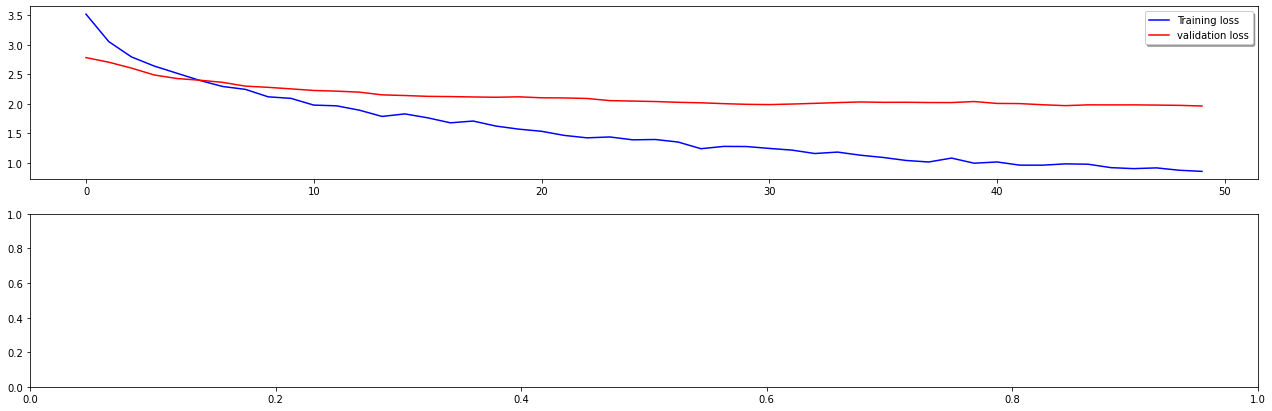

In [122]:
# Model Evaluation

fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

ValueError: ignored

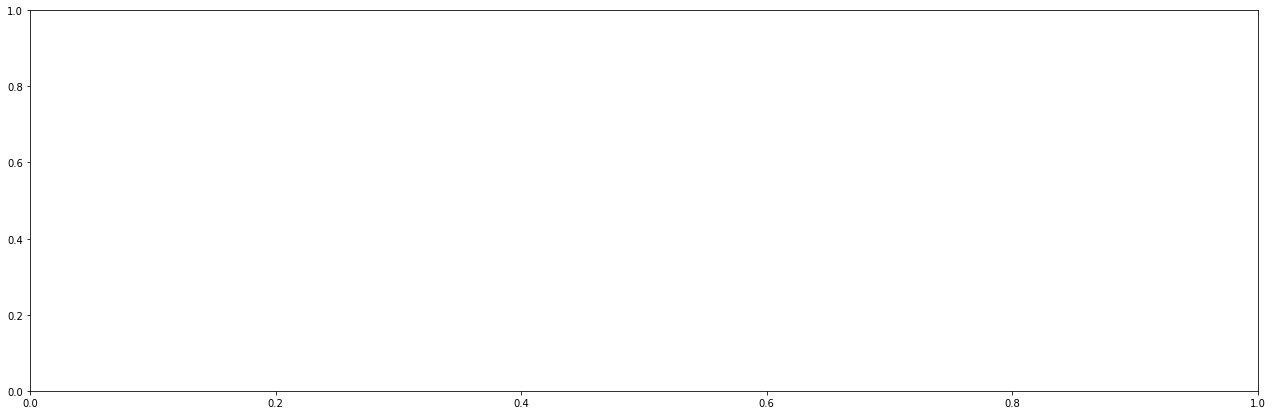

In [123]:
#
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [124]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2)

In [125]:
#batch size represents the number of traning examples used in one iteration
train_generator = datagen.flow(x_train,y_train,batch_size=32,shuffle=True,seed=42)

NameError: ignored

In [126]:
Validation_generator = datagen.flow(x_test,y_test,batch_size=32,shuffle=True,seed=42)

NameError: ignored

In [ ]:
model = Sequential()
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=opt)

model.fit_generator(
    generator,
    steps_per_epoch=None,
    epochs=1,
    verbose=1,
    callbacks=None,
    validation_data=None,
    validation_steps=None,
    validation_freq=1,
    class_weight=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    shuffle=True,
    initial_epoch=0,
)

In [ ]:
k.clear_session()
batch_size=32
history=model.fit_generator(train_generator,verbose=1,
                    steps_per_epoch=train_generator.n//batch_size,
                    validation_steps=Validation_generator.n//batch_size,
                    validation_data=Validation_generator,
                   epochs=10,max_queue_size=10, workers=5,class_weight=10, use_multiprocessing=False)

In [ ]:
model.evaluate(x_test,y_test)

D. Train a model using a basic CNN and share performance metrics on test data. [4 Marks]


In [ ]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(17, activation= tf.nn.softmax))

model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(x_train,
                    y_train,
                    epochs=30,
                    batch_size=batch_size,
                    validation_data=(x_test,y_test))


In [ ]:
0#Dense Layer model 2
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, kernel_regularizer=keras.regularizers.l2(0.1),activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dense(512, kernel_regularizer=keras.regularizers.l2(0.001),activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(17, activation= tf.nn.softmax))

model.compile(optimizer= keras.optimizers.RMSprop(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(x_train,
                    y_train,
                    epochs=30,
                    batch_size=batch_size,
                    validation_data=(x_test,y_test))


E. Predict the class/label of image ‘Prediction.jpg’ using best performing model and share predicted label. [2 Marks]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.imshow(testX[1],cmap='gray')
y_pred = model.predict('/content/drive/MyDrive/Prediction.jpg'.reshape(1,70,70,3))
print("Predicted label:", y_pred.argmax())
print("Softmax Outputs:", y_pred)
print(y_pred.sum())